In [1]:
import sys
import h5py
import numpy as np
import healpy as hp
import tensorflow as tf
import random as python_random
import nnhealpix.layers
import matplotlib.pyplot as plt
from tensorflow.keras import metrics
import keras
import pandas as pd
import os, shutil
from loss_functions import sigma_loss, sigma_f_loss, sigma2_loss,sigma_batch_loss,sigma_norm_loss,sigma_log_loss,mse_tau,mse_sigma

2023-06-11 12:17:50.169016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 12:17:51.818754: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-11 12:17:51.818955: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-11 12:17:51.818982: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
#metrics= [sigma_loss,sigma2_loss,sigma_batch_loss,sigma_norm_loss,sigma_log_loss,mse_tau,mse_sigma]
metrics= [sigma_loss,sigma_batch_loss,mse_tau,mse_sigma,sigma_f_loss]
home_dir="/home/amorelli/r_estimate/B_maps_white_noise/results_10_6_23/"

r_like=[0.0,0.01,0.03,0.05,0.06] #these are the r_test of the maps on which i test the NN 
sigma_exact=[0.00011*2, 0.00152323164284316, 0.00286355246354494,0.00376209725434054,0.0024*2]
to_load=["test_data_r000_t006_24.npz","test_data_r0010_t006_24.npz","test_data_r0030_t006_24.npz","test_data_r0050_t006_24.npz","test_data_r0060_t006_54.npz"]

#r_like=[0.0,0.001,0.005,0.007,0.01] #these are the r_test of the maps on which i test the NN 
#sigma_exact=[0.000225922*2, 0.000398311, 0.001017338,0.001142098,0.0015324*2] #these are the sigma computed for the 
#to_load=["test_data_r000_t006_50.npz","test_data_r001_t006_51.npz","test_data_r005_t006_52.npz",
         #"test_data_r007_t006_53.npz","test_data_r0010_t006_54.npz"] #these are the test maps

#r_test using the likelihood approach
#sigma_exact=[0.00073*2, 0.000398311, 0.00207732328746706,0.002335838427700651] tau 0.01,0.06,0.07,0.08
#to_load=["test_data_005_40.npz","test_data_007_40.npz"]

load_dir='/home/amorelli/r_estimate/B_maps_white_noise/' 
loss_kind="var" #var
loss_training=sigma_log_loss 
test_model_folder="test_model"

In [3]:
try:
    hyperparameters=pd.read_csv(home_dir+"output.txt",delim_whitespace=True, index_col=None) #i try to read the 
    #file with the hyperparameters used in the training
except:
    print("no file to read") 
    dataframe={}
    dataframe["no data"]=["-"]
    hyperparameters=pd.DataFrame(dataframe)#if there is no file to read (because i analyse an old model) i create an 
    #empty dataframe
finally:
    None #i use this so that the program continue after the try,except
print(hyperparameters)

      name  noise      lr  n_layers  nodes_layers  batch_size  p_reduce  \
0  10_6_23      4  0.0003      True            48          16         5   

   f_reduce  p_stopping stopping_monitor reduce_monitor  \
0       0.5          20         val_loss       val_loss   

                                            comments  
0  this is fine tuned on best model from tuning 1...  


In [4]:
files=[]
for name in to_load: 
    files.append(np.load(load_dir+name) )
x_test=[]
y_test=[]
for i,f in enumerate(files):#i take the maps and the corresponding r_test for each input file
    x_test.append(f["x_test"])
    y=np.zeros(len(x_test[i]))+f["y_test"] #y_test is a single number in the file -> i need to transform it in an array
    #of the same length of x_test
    y_test.append(y.reshape(y.shape[0],1))

In [5]:
model = keras.models.load_model(
    home_dir+test_model_folder,  custom_objects={'loss_training' : loss_training, 'metrics' : metrics}, 
    compile=False
) #i restore the model from the test_model folder. I need to specify the custom objects and recompile the model with the custom
#objects, thus the metrics and the loss functions
model.compile(loss=loss_training,optimizer=tf.optimizers.Adam(), metrics=metrics)

results=[]
predictions=[]
for x,y in zip(x_test,y_test): #i compute the predictions of the model for each test_set and save them in a dict
    results.append(model.evaluate(x,y,verbose=2) )
    predictions.append(model.predict(x))
npz_dict={}
for i,p in enumerate(predictions):
    npz_dict[f"sigma_{r_like[i]}"]=p[:,1]
np.savez(home_dir+"sigma_out", **npz_dict)

2023-06-11 12:18:08.399399: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-11 12:18:08.399570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (coka.fe.infn.it): /proc/driver/nvidia/version does not exist
2023-06-11 12:18:08.402962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


313/313 - 11s - loss: 6.1497e-06 - sigma_loss: 1.0109e-04 - sigma_batch_loss: 5.9409e-05 - mse_tau: 6.1433e-06 - mse_sigma: 9.4947e-05 - sigma_f_loss: 9494.7168 - 11s/epoch - 37ms/step
313/313 [==============================] - 10s 32ms/step
313/313 - 8s - loss: 7.6233e-05 - sigma_loss: 1.0315e-04 - sigma_batch_loss: 2.6005e-04 - mse_tau: 7.6155e-05 - mse_sigma: 2.7000e-05 - sigma_f_loss: 2700.0283 - 8s/epoch - 26ms/step
313/313 [==============================] - 8s 27ms/step
313/313 - 8s - loss: 2.8219e-04 - sigma_loss: 5.1544e-04 - sigma_batch_loss: 0.0013 - mse_tau: 2.8190e-04 - mse_sigma: 2.3354e-04 - sigma_f_loss: 23353.7559 - 8s/epoch - 27ms/step
313/313 [==============================] - 8s 26ms/step
313/313 - 9s - loss: 3.8055e-04 - sigma_loss: 7.7220e-04 - sigma_batch_loss: 0.0019 - mse_tau: 3.8017e-04 - mse_sigma: 3.9204e-04 - sigma_f_loss: 39203.7969 - 9s/epoch - 29ms/step
313/313 [==============================] - 9s 30ms/step
313/313 - 8s - loss: 6.3675e-04 - sigma_loss: 7

In [6]:
print(npz_dict[f"sigma_{r_like[0]}"])

[0.00170133 0.00177576 0.00178738 ... 0.0017476  0.00173499 0.00168651]


In [7]:
if loss_kind=="sigma": #if the output of the NN is directly the std i do some operations and print some values, if
    #it gives the variance i do in a different way
    r_pred=[]
    sigma_pred=[]
    r_est=[]
    sigma_r=[]
    sigma_est=[]
    sigma_sigma=[]
    mae_r=[]
    skeweness_r=[]
    skeweness_sigma=[]
    median_r=[]
    median_sigma=[]
    for i,p in enumerate(predictions): #i compute mean, std, etc for each set of predictions and save them in the corresponding
        #dictionaries (see above)
        r_pred.append(p[:,0])
        sigma_pred.append(p[:,1])
        r_est.append(np.mean(r_pred[i]))
        sigma_r.append(np.std(r_pred[i]))
        sigma_est.append(np.mean(sigma_pred[i]))
        sigma_sigma.append(np.std(sigma_pred[i]))
        mae_r.append(np.sum(np.abs(r_pred[i]-r_est[i]))/len(r_pred[i]))
        skeweness_r.append(np.sum(((r_pred[i]-r_est[i])/sigma_r[i])**3)/len(r_pred[i]))
        skeweness_sigma.append(np.sum(((sigma_pred[i]-sigma_est[i])/sigma_sigma[i])**3)/len(r_pred[i]))
        median_r.append(np.median(r_pred[i]))
        median_sigma.append(np.median(sigma_pred[i]))
    #r_test=np.asarray([int(x*100)/100 for x in r_est])
    #sigma_like=np.empty_like(r_test,dtype=float)
    #for r in r_test:
        #i=r_like.index(r)
        #sigma_like[i]=sigma_exact[i]
    d={}# i create a dictionary that stores the value of the following keywords for each test_set
    d["r_test"]=r_like
    d["r_est"]=r_est
    d["dr"]=np.abs(np.asarray(r_like)-np.asarray(r_est))/r_est
    d["median_r-r_est"]=np.asarray(median_r)-np.asarray(r_est)
    d["mae_r"]=mae_r
    d["skeweness_r"]=skeweness_r
    d["sigma_r"]=sigma_r
    d["sigma_est"]=sigma_est
    d["dsigma"]=np.abs(np.asarray(sigma_r)-np.asarray(sigma_est))/sigma_est
    d["dlike"]=np.abs(np.asarray(sigma_r)-np.asarray(sigma_exact))/sigma_r
    d["sigma_sigma"]=sigma_sigma
    d["median_sigma-sigma_est"]=np.asarray(median_sigma)-np.asarray(sigma_est)
    d["skeweness_sigma"]=skeweness_sigma

    r_data=pd.DataFrame(d)

    #define new DataFrame as original DataFrame with each row repeated 3 times. I do this because i want to join the hyperpar. dataframe
    #with the r_data dataframe and the hyperparam. dataframe only has one row
    hp_new = pd.DataFrame(np.repeat(hyperparameters.values, len(r_est), axis=0))
    #assign column names of original DataFrame to new DataFrame
    hp_new.columns = hyperparameters.columns

    out_df = pd.concat([hp_new, r_data], axis=1) # i join the two dataframes so that i can copy-paste all the info for one model directly
    #in excel

    print(out_df)
    out_df.to_csv(home_dir+'results.txt', index=False, sep=';')

In [8]:
if loss_kind=="sigma": 
    for i in range(len(r_pred)):
        print("on_test_set r =",r_like[i])
        print("r_est:",r_est[i],"  This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.")
        print("sigma_r:",sigma_r[i], " This is the std of the $r_i^{NN}$ array (std of the prediction).")
        print("sigma_r_est:", sigma_est[i], "  This is the average of the $\sigma_{i}$ estimated by the network on the test set.")
        print("\n")

In [9]:
#print(r_pred[0][:100])

In [10]:
if loss_kind=="sigma":
    fig, ax = plt.subplots(len(r_pred),2, figsize = (12,20))
    for i in range(len(r_pred)): #for each test_set i create an histogram of the r_pred and sigma_pred and print both 
        bin_size=100
        bin_edges= np.histogram_bin_edges(r_pred[i], bins='fd')
        print("n_of_bins:",len(bin_edges))
        counts_tau, bins_tau = np.histogram(r_pred[i], bins=bin_edges) 
        bin_edges= np.histogram_bin_edges(np.abs(sigma_pred[i]), bins='fd')
        counts_sigma, bins_sigma = np.histogram(np.abs(sigma_pred[i]), bins=bin_edges)
        plt.subplot(len(r_pred),2,2*i+1)
        plt.stairs(counts_tau, bins_tau, label="r",  color='k')
        plt.axvline(r_like[i], color="black", linestyle="--", label="r_test")
        #plt.axvline(median_r[i], color="black", linestyle="--", label="r_test")
        plt.axvline(r_est[i], color="red", linestyle="-", label="r_est")
        plt.legend()
        plt.xlabel("$r$")
        plt.ylabel("$counts$")
        plt.ticklabel_format(style='sci',useOffset=True, axis='x', scilimits=[-1, 1])
        plt.subplot(len(r_pred),2,2*i+2)
        plt.stairs(counts_sigma, bins_sigma, label="std estimated by NN",  color='k')
        plt.axvline(sigma_r[i], color="black", linestyle="--", label="std on the r estimated by NN")
        plt.axvline(np.abs(sigma_est[i]), color="red", linestyle="-", label="Average of the std estimated by NN")
        plt.legend()
        plt.ticklabel_format(style='sci',useOffset=True, axis='x', scilimits=[-1, 1])
        plt.xlabel("$\sigma_{r}^{NN}$")
        plt.ylabel("$counts$")
        plt.legend()
        #print(counts_tau, bins_tau)
        #print(np.sort(r_pred[i]))
    #plt.savefig('results_on_test.jpg') #must be in same cell or result image will be blank

In [11]:
if loss_kind!="sigma": #if the output of the NN is directly the std i do some operations and print some values, if
    #it gives the variance i do in a different way
    r_pred=[]
    var_pred=[]
    r_est=[]
    sigma_r=[]
    sigma_est=[]
    sigma_var=[]
    mae_r=[]
    skeweness_r=[]
    skeweness_var=[]
    median_r=[]
    median_var=[]
    for i,p in enumerate(predictions): #i compute mean, std, etc for each set of predictions and save them in the corresponding
        #dictionaries (see above)
        r_pred.append(p[:,0])
        #var_pred.append(p[:,1])
        var_pred.append(p[:,1]**2)
        r_est.append(np.mean(r_pred[i]))
        sigma_r.append(np.std(r_pred[i]))
        sigma_est.append(np.sqrt(np.mean(var_pred[i])))
        sigma_var.append(np.std(var_pred[i]))
        mae_r.append(np.sum(np.abs(r_pred[i]-r_est[i]))/len(r_pred[i]))
        skeweness_r.append(np.sum(((r_pred[i]-r_est[i])/sigma_r[i])**3)/len(r_pred[i]))
        skeweness_var.append(np.sum(((var_pred[i]-sigma_est[i]**2)/sigma_var[i])**3)/len(r_pred[i]))
        median_r.append(np.median(r_pred[i]))
        median_var.append(np.median(var_pred[i]))
    #r_test=np.asarray([int(x*100)/100 for x in r_est])
    #sigma_like=np.empty_like(r_test,dtype=float)
    #for r in r_test:
        #i=r_like.index(r)
        #sigma_like[i]=sigma_exact[i]
    d={}# i create a dictionary that stores the value of the following keywords for each test_set
    d["r_test"]=r_like
    d["r_est"]=r_est
    d["dr"]=np.abs(np.asarray(r_like)-np.asarray(r_est))/r_est
    d["median_r-r_est"]=np.asarray(median_r)-np.asarray(r_est)
    d["mae_r"]=mae_r
    d["skeweness_r"]=skeweness_r
    d["sigma_r"]=sigma_r
    d["sigma_est"]=sigma_est
    d["dsigma"]=np.abs(np.asarray(sigma_r)-np.asarray(sigma_est))/sigma_est
    d["dlike"]=np.abs(np.asarray(sigma_r)-np.asarray(sigma_exact))/sigma_r
    d["sigma_var"]=sigma_var
    d["median_var-var_est"]=np.asarray(median_var)-np.asarray(sigma_est)**2
    d["skeweness_var"]=skeweness_var

    r_data=pd.DataFrame(d)

    #define new DataFrame as original DataFrame with each row repeated 3 times. I do this because i want to join the hyperpar. dataframe
    #with the r_data dataframe and the hyperparam. dataframe only has one row
    hp_new = pd.DataFrame(np.repeat(hyperparameters.values, len(r_est), axis=0))
    #assign column names of original DataFrame to new DataFrame
    hp_new.columns = hyperparameters.columns

    out_df = pd.concat([hp_new, r_data], axis=1) # i join the two dataframes so that i can copy-paste all the info for one model directly
    #in excel

    print(out_df)
    out_df.to_csv(home_dir+'results.txt', index=False, sep=';')

      name noise      lr n_layers nodes_layers batch_size p_reduce f_reduce  \
0  10_6_23     4  0.0003     True           48         16        5      0.5   
1  10_6_23     4  0.0003     True           48         16        5      0.5   
2  10_6_23     4  0.0003     True           48         16        5      0.5   
3  10_6_23     4  0.0003     True           48         16        5      0.5   
4  10_6_23     4  0.0003     True           48         16        5      0.5   

  p_stopping stopping_monitor  ... median_r-r_est     mae_r  skeweness_r  \
0         20         val_loss  ...      -0.000038  0.000220     0.862208   
1         20         val_loss  ...      -0.000059  0.001220     0.253618   
2         20         val_loss  ...       0.000118  0.002327    -0.036324   
3         20         val_loss  ...       0.000105  0.002802    -0.318155   
4         20         val_loss  ...       0.000171  0.001394    -1.060297   

    sigma_r  sigma_est    dsigma     dlike     sigma_var  median_var

In [12]:
if loss_kind!="sigma": 
    for i in range(len(r_pred)):
        print("on_test_set r =",r_like[i])
        print("r_est:",r_est[i],"  This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.")
        print("sigma_r:",sigma_r[i], " This is the std of the $r_i^{NN}$ array (std of the prediction).")
        print("sigma_r_est:", sigma_est[i], "  This is the square root of the average of the $\sigma_{i}$ estimated by the network on the test set. In this case the sigma_i is indeed an estimate of the variance")
        print("\n")

on_test_set r = 0.0
r_est: 0.0003346178   This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.
sigma_r: 0.00028339904  This is the std of the $r_i^{NN}$ array (std of the prediction).
sigma_r_est: 0.0017240884   This is the square root of the average of the $\sigma_{i}$ estimated by the network on the test set. In this case the sigma_i is indeed an estimate of the variance


on_test_set r = 0.01
r_est: 0.010159123   This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.
sigma_r: 0.0015356814  This is the std of the $r_i^{NN}$ array (std of the prediction).
sigma_r_est: 0.0009167587   This is the square root of the average of the $\sigma_{i}$ estimated by the network on the test set. In this case the sigma_i is indeed an estimate of the variance


on_test_set r = 0.03
r_est: 0.030461213   This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.
sigma_r: 0.0029344019  This is the std of the $r_i^{NN}$ array 

n_of_bins: 77
n_of_bins: 70
n_of_bins: 70
n_of_bins: 51
n_of_bins: 113


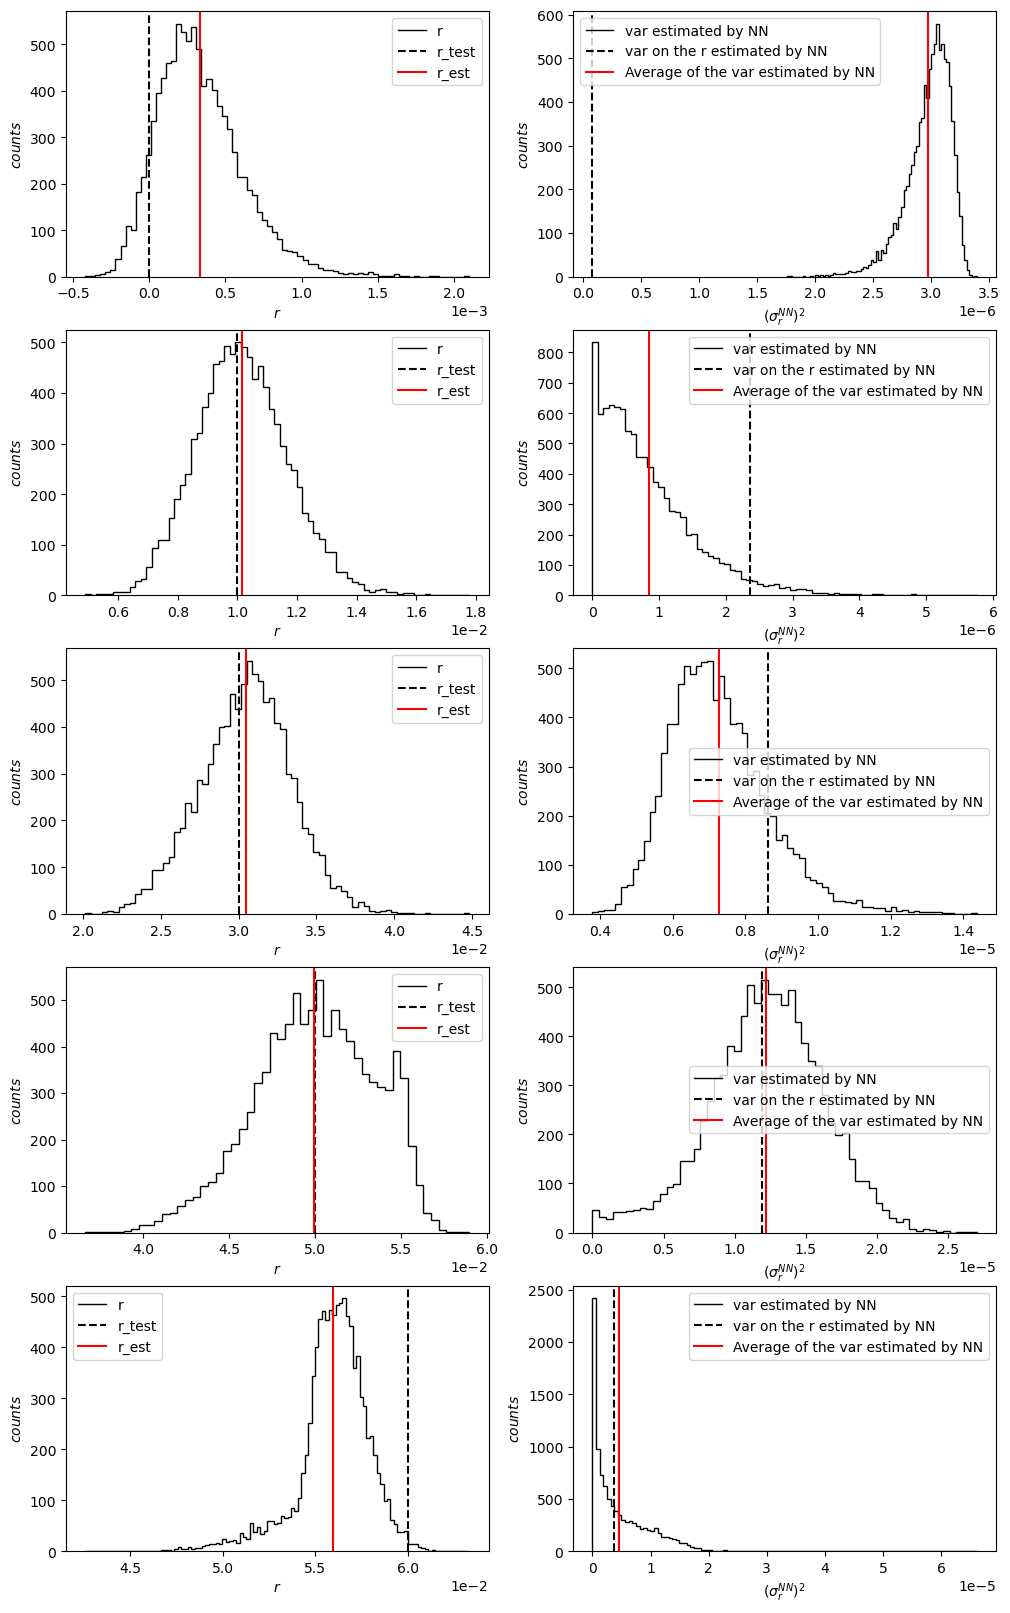

In [13]:
if loss_kind!="sigma":
    fig, ax = plt.subplots(len(r_pred),2, figsize = (12,20))
    for i in range(len(r_pred)): #for each test_set i create an histogram of the r_pred and sigma_pred and print both 
        bin_size=100
        bin_edges= np.histogram_bin_edges(r_pred[i], bins='fd')
        print("n_of_bins:",len(bin_edges))
        counts_tau, bins_tau = np.histogram(r_pred[i], bins=bin_edges) 
        bin_edges= np.histogram_bin_edges(var_pred[i], bins='fd')
        counts_sigma, bins_sigma = np.histogram(var_pred[i], bins=bin_edges)
        plt.subplot(len(r_pred),2,2*i+1)
        plt.stairs(counts_tau, bins_tau, label="r",  color='k')
        plt.axvline(r_like[i], color="black", linestyle="--", label="r_test")
        #plt.axvline(median_r[i], color="black", linestyle="--", label="r_test")
        plt.axvline(r_est[i], color="red", linestyle="-", label="r_est")
        plt.legend()
        plt.xlabel("$r$")
        plt.ylabel("$counts$")
        plt.ticklabel_format(style='sci',useOffset=True, axis='x', scilimits=[-1, 1])
        plt.subplot(len(r_pred),2,2*i+2)
        plt.stairs(counts_sigma, bins_sigma, label="var estimated by NN",  color='k')
        plt.axvline(sigma_r[i]**2, color="black", linestyle="--", label="var on the r estimated by NN")
        plt.axvline(sigma_est[i]**2, color="red", linestyle="-", label="Average of the var estimated by NN")
        plt.legend()
        plt.ticklabel_format(style='sci',useOffset=True, axis='x', scilimits=[-1, 1])
        plt.xlabel("$(\sigma_{r}^{NN})^2$")
        plt.ylabel("$counts$")
        plt.legend()
        #print(counts_tau, bins_tau)
        #print(np.sort(r_pred[i]))
    #plt.savefig('results_on_test.jpg') #must be in same cell or result image will be blank